In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("ac209b_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 (209) - Clustering: GMM




**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas 


<hr style="height:2pt">

In [2]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans

import seaborn as sns
import scipy as sp
from sklearn.datasets import make_spd_matrix

from matplotlib.patches import Ellipse

In [4]:
# Some matplotlib settings
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'x'
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['lines.markersize'] = 10

<a id="contents"></a>

# Generating Our Data

Here is the data we'll be modeling in this notebook.

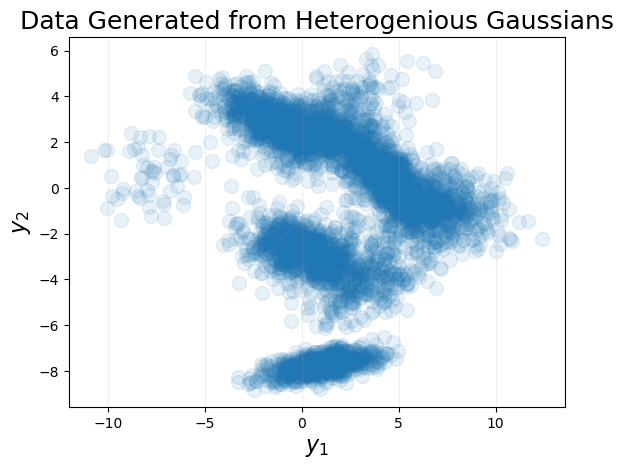

In [5]:
# data generation from random gaussians
N = 5_000
np.random.seed(2023)
K_true = np.random.choice(range(1,11), 1)[0]
pis_unnorm = np.random.uniform(0,1, size=K_true)
pis = pis_unnorm/pis_unnorm.sum()
mus = np.array([np.random.multivariate_normal(np.random.randn(2), 15*np.eye(2), size=1) for k in range(K_true)]).reshape(-1,2)
covs = np.array([make_spd_matrix(len(mus[0])) for k in range(K_true)])
zs = np.random.choice(np.arange(len(pis)), size=N, p=pis)
Y = np.array([np.random.multivariate_normal(mus[z], covs[z], 1)[0] for z in zs])
plt.scatter(*Y.T, alpha=0.1)
plt.title('Data Generated from Heterogenious Gaussians')
plt.xlabel('$y_1$')
plt.ylabel('$y_2$');

We could try KMeans for $k\in\{1,2,\dots,10\}$

In [6]:
kms = [KMeans(k, n_init=5).fit(Y) for k in range(1,11)]

And analyze our results.

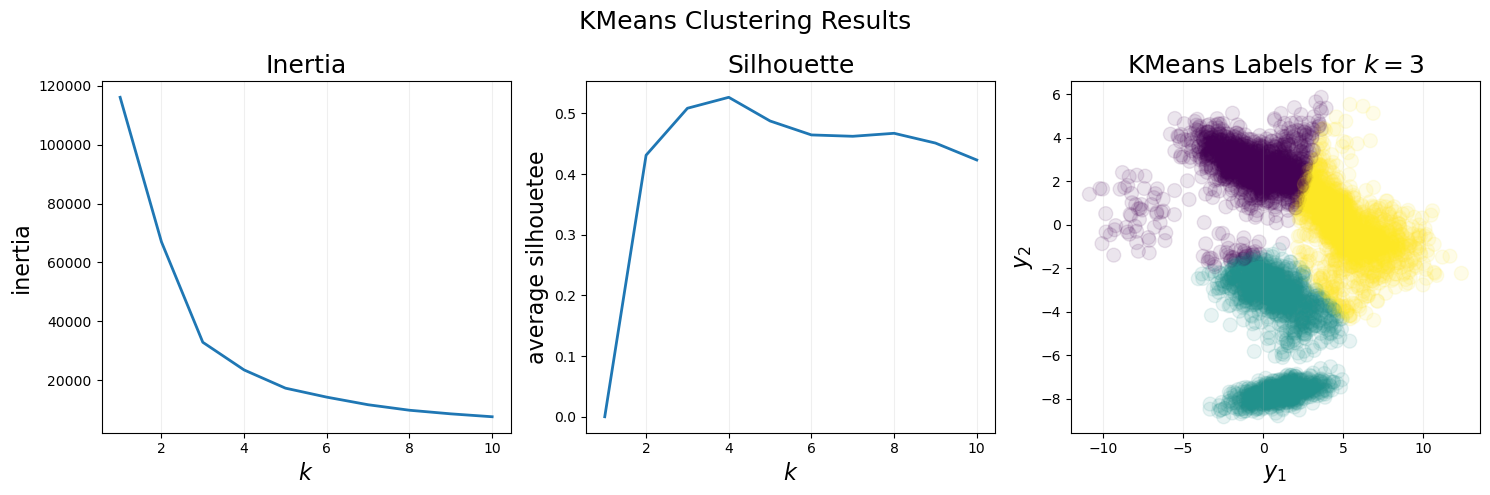

In [7]:
fix, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(range(1,11), [km.inertia_ for km in kms])
axs[0].set(xlabel='$k$', ylabel='inertia', title='Inertia')
axs[1].plot(range(1,11), [0]+[silhouette_score(Y, km.labels_) for km in kms[1:]])
axs[1].set(xlabel='$k$', ylabel='average silhouetee', title='Silhouette')
optimalk = 3
axs[2].scatter(*Y.T, alpha=0.1, c=kms[optimalk-1].labels_)
axs[2].set(xlabel='$y_1$', ylabel='$y_2$', title=f"KMeans Labels for $k={optimalk}$")
plt.suptitle('KMeans Clustering Results')
plt.tight_layout()

As a compromise between the inertia and the silhouette score we might select $k=3$ (there is a pretty clear elbow in the inertia here and it is *almost* the max silhouette).

However, the resulting clusters don't appear to fit the data well. Even if $k=3$ were the true number of Gaussians this doesn't seem to be the ideal way to assign the points. There's got to be a better way!

<a id="part1"></a>

## <div class='exercise'> Gaussian Mixture Models </div>

[Return to contents](#contents)

<div class='exercise-r'>

**1.1**
    
In a ***Gaussian Mixture Model (GMM)***, we posit that the observed data $Y$ is generated by a mixture of $K$ of Gaussians each with their own set of parameters. For each observation $Y_n$ the class of the observation $Z_n$ is a latent variable that indicates which of the $K$ Gaussian is responsible for generating $Y_n$:

We'll begin by modeling the data above with a mixture of **$k=3$ Gaussians**.
    
Write down a representation of this model, including all parameters and any latent variables.
    
**Note:** You should model the entire covariance matrix of each Gaussian

</div>

The observed data $Y$ is generated by a mixture of $K=3$ Gaussians with means $\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \boldsymbol{\mu}_3$, and covariance matrices $\boldsymbol{\Sigma}_1, \boldsymbol{\Sigma}_2, \boldsymbol{\Sigma}_3$, respectively.

For each observation $Y_n$, the class of the observation $Z_n$ is a latent variable that indicates which of the $K$ Gaussians is responsible for generating $Y_n$. $Z_n$ is a categorical variable that takes one of the values from the set ${1, 2, 3}$.
The mixture proportions $\boldsymbol{\pi} = {\pi_1, \pi_2, \pi_3}$ represent the probability of each Gaussian generating the data. These proportions must satisfy $\pi_k \geq 0$ and $\sum_{k=1}^{K} \pi_k = 1$.
Therefore, the complete set of parameters and latent variables for the GMM with $k=3$ Gaussians is:

- $\boldsymbol{\mu}_1$, $\boldsymbol{\mu}_2$, $\boldsymbol{\mu}_3$: The means of the three Gaussians.
- $\boldsymbol{\Sigma}_1$, $\boldsymbol{\Sigma}_2$, $\boldsymbol{\Sigma}_3$: The covariance matrices of the three Gaussians.
- $\boldsymbol{\pi} = {\pi_1, \pi_2, \pi_3}$: The mixture proportions.
- $Z_n$: The class of the observation $Y_n$.
- $Y_n$: The observed data.


Modeling the entire covariance matrix for each Gaussian is a more general approach than assuming diagonal covariance matrices, and it can capture complex dependencies between the features.

In this case, each Gaussian is characterized by a mean vector $\boldsymbol{\mu}_k$ and a covariance matrix $\boldsymbol{\Sigma}_k$. The covariance matrix $\boldsymbol{\Sigma}_k$ is a positive definite matrix with dimension $D \times D$, where $D$ is the number of features in the data.

The joint probability density function of the GMM can be written as:


$$p(\mathbf{Y},\mathbf{Z}|\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Sigma}) = \prod_{n=1}^{N}\prod_{k=1}^{K} \left[ \pi_k \mathcal{N}(\mathbf{Y}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}k) \right]^{Z_{nk}}$$	
 
 
where $\boldsymbol{\pi} = {\pi_1, \dots, \pi_K}$ are the mixing coefficients, $\boldsymbol{\mu} = {\boldsymbol{\mu}_1, \dots, \boldsymbol{\mu}_K}$ are the means of the Gaussians, $\boldsymbol{\Sigma} = {\boldsymbol{\Sigma}_1, \dots, \boldsymbol{\Sigma}_K}$ are the covariance matrices of the Gaussians, and $\mathbf{Z}$ are the latent variables indicating the cluster assignments.

Each observation $\mathbf{Y}n$ is generated from one of the $K$ Gaussians, indicated by the corresponding $Z_{nk}$, which is a binary indicator variable that takes a value of 1 if the observation $\mathbf{Y}_n$ was generated by the $k$-th Gaussian, and 0 otherwise. The clustering assignment $\mathbf{Z}$ is therefore a binary matrix of size $N \times K$.

<div class='exercise-r'>

**1.2**
    
Now we'll start constructing the model in code.\
Initialize the parameters of your model. Call these variables `pi`, `mu`, `cov`.
    
Then plot the centers of your initialized distributions on top of a scatter plot data to see where we are starting from.

Some suggestions:
* The Guassian mixture weights, `pi`, should start out equal (i.e., data points are equally likely to be generated from any one of the Gaussians)
* Sample some of the data points to serve as the initial Gaussian centers. Just take care that you don't choose the same point more than once!
* SKLearn's `make_spd_matrix` can be used to genererate a symetric, positive semidefinite matricies (which are valid covariance matrices)

**Note:** here and else where cells have random seeds set at the top. Please try not to delete these as they help insure some degree of similarity across results.
</div>

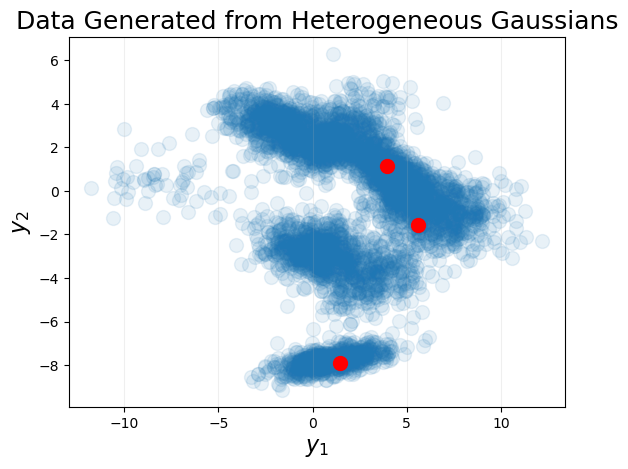

In [8]:
# Set the seed for the random number generator to ensure reproducibility
np.random.seed(209)

# Define the number of mixture components
K = 3

# Set the prior probabilities of each component to be uniform
pi = np.full((K,), 1/K)

# Generate data from random Gaussian distributions
N = 5_000

# Choose three random indices from the data
idx = np.random.choice(Y.shape[0], size= 3, replace=False)

# Set the means of the Gaussian distributions to be the data points with the selected indices
mu = Y[idx]

# Set the seed for the random number generator for generating the true number of components
np.random.seed(2023)

# Choose the true number of mixture components randomly from 1 to 10
K_true = np.random.choice(range(1,11), 1)[0]

# Generate the unnormalized prior probabilities for each component randomly
pis_unnorm = np.random.uniform(0,1, size=K_true)

# Normalize the prior probabilities
pis = pis_unnorm/pis_unnorm.sum()

# Generate random means for each component using multivariate normal distributions
# with random covariance matrices
mus = np.array([np.random.multivariate_normal(np.random.randn(2), 15*np.eye(2), size=1) for k in range(K_true)]).reshape(-1,2)

# Generate random covariance matrices for each component using the make_spd_matrix function
cov = np.array([make_spd_matrix(len(mus[0])) for k in range(K)])

# Assign each data point to a component randomly based on the prior probabilities
zs = np.random.choice(np.arange(len(pis)), size=N, p=pis)

# Generate data points from the Gaussian mixture distribution
Y = np.array([np.random.multivariate_normal(mus[z], covs[z], 1)[0] for z in zs])

# Plot the generated data points and the means of the components used to generate the data
plt.scatter(*Y.T, alpha=0.1)
plt.scatter(*mu.T, color='red')
plt.title('Data Generated from Heterogeneous Gaussians')
plt.xlabel('$y_1$')
plt.ylabel('$y_2$');


In [9]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<div class='exercise-r'>

**1.3**
    
Use $\LaTeX$ to write out the calculations and parameter update rules for your model when performing the EM algorithm.
    
    
**Hint:** Consult the EM Algorithm described in the a-section slides and notebook.


</div>

1. Initialization step: Initialize the parameters of the model to some initial values.

2. Expectation Step: Compute the posterior distribution of the latent variables given the observed data and the current estimates of the parameters. This involves calculating the expected value of the log-likelihood function with respect to the posterior distribution of the latent variables.

$$Q(\theta | \theta^{(t)}) = E_{z|y,\theta^{(t)}} [ \log p(y, z | \theta)]$$

where $y$ is the observed data, $z$ is the latent variable, $\theta$ are the model parameters, and $\theta^{(t)}$ are the parameter estimates at iteration $t$.




3. Maximization Step: Maximize the expected log-likelihood function from the E step with respect to the parameters. This involves computing the partial derivatives of the expected log-likelihood function with respect to each of the parameters and setting them to zero to obtain the maximum likelihood estimates of the parameters.

Update the parameters $\pi_k$, $\boldsymbol{\mu}_k$, and $\boldsymbol{\Sigma}k$ to maximize $Q(\theta | \theta^{(t)})$. The update rules for the individual parameters are as follows:

$$\pi_k = \frac{\sum{n=1}^N r_{nk}}{N}$$
$$\boldsymbol{\mu}_k = \frac{\sum{n=1}^N r_{nk} y_n}{\sum_{n=1}^N r_{nk}}$$
$$\boldsymbol{\Sigma}_k = \frac{\sum{n=1}^N r_{nk} (y_n - \boldsymbol{\mu}_k)(y_n - \boldsymbol{\mu}_k)^T}{\sum{n=1}^N r_{nk}}$$

Where $r_{ik}$ is the responsibility of cluster $k$ for data point $i$, and $n$ is the number of data points:
$$r_{nk} = \frac{\pi_k \mathcal{N}(y_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum{j=1}^K \pi_j \mathcal{N}(y_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$

Note that in the case of the spherical Gaussian mixture model, the covariance matrix $\boldsymbol{\Sigma}_k$ simplifies to a scalar value:

$$\boldsymbol{\Sigma}_k = \frac{\sum{n=1}^N r_{nk} (y_n - \boldsymbol{\mu}_k)^2}{\sum{n=1}^N r_{nk}}$$

<div class='exercise-r'>

**1.4**
    
Implement EM for 200 iterations. Updating your orginal parameters at each iterations.

Conclude by using the provided `plot_gaussians` function to visualize the mixture of Gaussians your model has converged to.
</div>

In [10]:
from scipy.stats import multivariate_normal

In [11]:
np.random.seed(209)  # Set the random seed for reproducibility
K = 3  # Set the number of clusters/components for the GMM
max_iter = 200  # Set the maximum number of iterations for the EM algorithm
for i in range(max_iter):
    # E-step: calculate the responsibilities r_ij
    r = np.zeros((N, K))  # Initialize the responsibilities matrix
    for k in range(K):
        r[:, k] = pi[k] * multivariate_normal.pdf(Y, mean=mu[k], cov=cov[k])
        # Calculate the probability of each data point belonging to cluster k
        # using the current estimates of pi, mu, and cov
    r_sum = np.sum(r, axis=1)  # Calculate the sum of probabilities for each data point
    r_sum[r_sum == 0] = 1e-16  # Avoid division by zero by setting any zero values to a small non-zero value
    r = r / r_sum[:, None]  # Normalize the probabilities to obtain the responsibilities
    
    # M-step: update the parameters pi, mu, and cov using the responsibilities
    N_k = np.sum(r, axis=0)  # Calculate the effective number of points in each cluster
    pi = N_k / N  # Update the mixing coefficients
    mu = np.dot(r.T, Y) / N_k[:, None]  # Update the means
    for k in range(K):
        y_centered = Y - mu[k]  # Calculate the centered data points
        cov[k] = np.dot((r[:, k] * y_centered.T), y_centered) / N_k[k]
        # Update the covariance matrices using the centered data points and responsibilities
        
    # Calculate the log-likelihood of the data under the current estimates of pi, mu, and cov
    if i % 10 == 0:  # Print the log-likelihood every 10 iterations
        ll = np.sum(np.log(np.sum(pi[k] * multivariate_normal.pdf(Y, mean=mu[k], cov=cov[k]) for k in range(K))))
        print(f"Iteration {i}: log-likelihood = {ll}")  # Print the iteration number and log-likelihood


/var/folders/bn/mhzy3bp10bl99gcw6tpnkhcc0000gn/T/ipykernel_49599/1919879426.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ll = np.sum(np.log(np.sum(pi[k] * multivariate_normal.pdf(Y, mean=mu[k], cov=cov[k]) for k in range(K))))


Iteration 0: log-likelihood = -24213.421944163503
Iteration 10: log-likelihood = -22997.488316245537
Iteration 20: log-likelihood = -22926.26074129602
Iteration 30: log-likelihood = -22926.26072731956
Iteration 40: log-likelihood = -22926.26072731956
Iteration 50: log-likelihood = -22926.260727319557
Iteration 60: log-likelihood = -22926.260727319557
Iteration 70: log-likelihood = -22926.260727319557
Iteration 80: log-likelihood = -22926.260727319557
Iteration 90: log-likelihood = -22926.260727319557
Iteration 100: log-likelihood = -22926.260727319557
Iteration 110: log-likelihood = -22926.260727319557
Iteration 120: log-likelihood = -22926.260727319557
Iteration 130: log-likelihood = -22926.260727319557
Iteration 140: log-likelihood = -22926.260727319557
Iteration 150: log-likelihood = -22926.260727319557
Iteration 160: log-likelihood = -22926.260727319557
Iteration 170: log-likelihood = -22926.260727319557
Iteration 180: log-likelihood = -22926.260727319557
Iteration 190: log-likelih

In [12]:
def plot_gaussians(Y, pi, mu, cov):
    M = 200 # num grid points
    y1 = np.linspace(Y[:,0].min(), Y[:,0].max(), M)
    y2 = np.linspace(Y[:,1].min(), Y[:,1].max(), M)
    yy1, yy2 = np.meshgrid(y1,y2)
    YY = list(zip(yy1.flatten(), yy2.flatten()))
    
    plt.figure(figsize=(8,8))
    plt.scatter(yy1.flatten(), yy2.flatten())
    K = len(mu)
    for k in range(K):
        Z = sp.stats.multivariate_normal(mu[k], cov[k]).pdf(YY)
        plt.contour(yy1, yy2, pi[k]*Z.reshape(M,M), alpha=1)
    plt.scatter(*Y.T, alpha=0.5)
    plt.scatter(*mu.T)
    plt.xlabel('$y_1$')
    plt.ylabel('$y_2$')
    plt.title(f'GMM results for $k = {len(pi)}$')

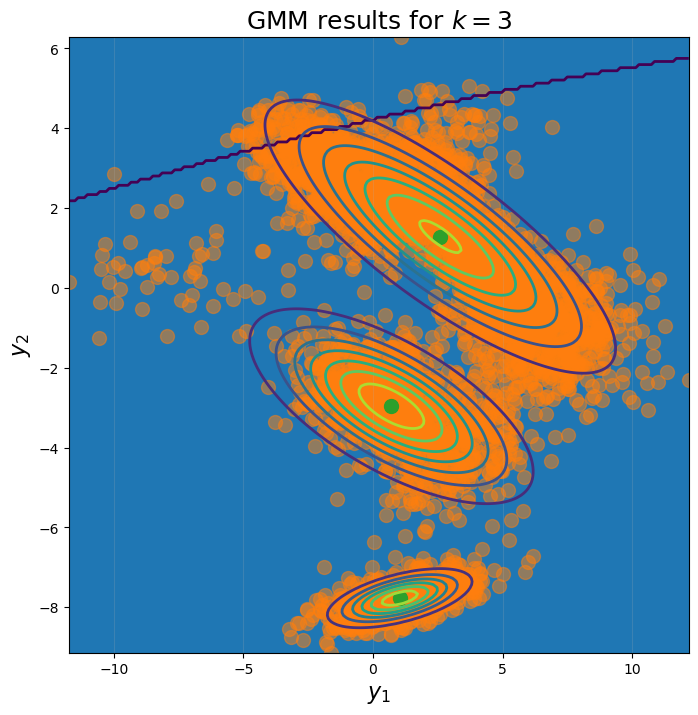

In [13]:
# your code here
plot_gaussians(Y, pi, mu, cov)

In [14]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<div class='exercise-r'>

**1.5** Write an expression showing how one could generate 'hard' cluster labels for data point $x_i$ based on the model parameters. By "cluster label" we mean a marker designating the Gaussian distribution that most likely generated a given data point.
    
</div>


For a given data point $x_i$, we can generate "hard" cluster labels by selecting the Gaussian distribution $k$ that maximizes the posterior probability of $z_i=k$ given $x_i$ and the current model parameters $\theta$:

$$\hat{z}_i = \operatorname*{argmax}{k} \frac{\pi_k N(x_i|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j N(x_i|\mu_j, \Sigma_j)}$$

Here, $\hat{z}_i$ is the selected cluster label for data point $x_i$, $\pi_k$ is the weight of the $k$-th Gaussian, $N(x_i|\mu_k, \Sigma_k)$ is the Gaussian probability density function with mean $\mu_k$ and covariance matrix $\Sigma_k$, and $K$ is the total number of Gaussian distributions in the mixture. The denominator in the expression represents the marginal likelihood of $x_i$ under the entire mixture model. The selected cluster label for $x_i$ is the index $k$ that maximizes the posterior probability.

<div class='exercise-r'>

**1.6**  Write down the model's log-likelihood function.
    
</div>


In the case of a Gaussian mixture model, the observed data is generated from a mixture of $K$ Gaussians, each with its own mean and covariance matrix. Each data point $y_n$ is assumed to have been generated by one of the $K$ Gaussians with some probability. The probability of a data point $y_n$ being generated by the $k$-th Gaussian is given by $\pi_k\mathcal{N}(y_n|\mu_k,\Sigma_k)$, where $\pi_k$ is the mixing coefficient for the $k$th Gaussian and $\mathcal{N}(y_n|\mu_k,\Sigma_k)$ is the probability density function of a multivariate Gaussian distribution with mean $\mu_k$ and covariance matrix $\Sigma_k$.

Therefore, the log-likelihood function for a Gaussian mixture model is the logarithm of the product of the probabilities of all the data points being generated by any of the $K$ Gaussians, summed over all possible Gaussians. This can be written as:

$$\ln \left(\prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(y_n|\mu_k,\Sigma_k) \right)$$

where $N$ is the number of data points.

Adding on to this with the `scikit-learn` documentation, for a linear Gaussian model, the maximum log-likelihood is given by:

$$log(\hat{L}) = -\frac{n}{2}log(2\pi) - \frac{n}{2}ln(\sigma^2) - \frac{\Sigma_{i=1}^n(y_i - \hat{y_i})^2}{2\sigma^2}$$

where $\sigma^2$ is an estimate of the nosie variance, $y_i$ and $\hat{y_i}$ are respectively the true and predicted targets, and $n$ is the number of samples. 

<div class='exercise-r'>

**1.7**  For each $k \in \{1, 2, \dots, 10\}$, re-initialize all parameters and runs 200 iterations of the EM algorithm. Store each model's final average silhouette score and log likelihood in the lists `sil_scores` and `log_lkhd` respectively. We'll use these metrics to evaluate different choices of $k$.
    
**Hint:** You'll need cluster labels to calculated the silhouette score
</div>


In [15]:
# set random seed to ensure reproducibility
np.random.seed(109)

# initialize variables
max_k = 10 # maximum number of clusters to consider
sil_scores = [] # list to store silhouette scores for each k
log_lkhd = [] # list to store the log-likelihood of each k
lkhd = [] # list to store the likelihood of each k

# loop over k from 1 to max_k
for K in range(1, max_k+1):
    
    # initialize parameters
    pis_unnorm = np.random.uniform(0, 1, size=K) # unnormalized mixing coefficients
    pis = pis_unnorm / pis_unnorm.sum() # mixing coefficients
    mus = np.array([np.random.multivariate_normal(np.random.randn(2), 
                                                  15*np.eye(2), 
                                                  size=1) for j in range(K)]).reshape(-1, 2) 
    # means of the Gaussian distributions, drawn from a normal distribution with mean 0 and covariance 15I
    covs = np.array([make_spd_matrix(len(mus[0])) for k in range(K)]) 
    # covariance matrices, generated as positive semi-definite matrices
    
    # perform E-M algorithm for 200 iterations
    for i in range(200):
        
        # E-step
        Qs = np.zeros((len(Y), K)) # initialize Qs
        for k in range(K):
            Qs[:, k] = pis[k] * multivariate_normal.pdf(Y, mean=mus[k], cov=covs[k])
            # compute the probability density function for each data point in Y under the k-th Gaussian distribution
            # weighted by the mixing coefficient pis[k]
        Qs = Qs / np.sum(Qs, axis=1)[:, np.newaxis] # normalize Qs
        
        # M-step
        Ns = np.sum(Qs, axis=0) # compute the effective number of points assigned to each cluster
        pis = Ns / len(Y) # update the mixing coefficients
        mus = np.dot(Qs.T, Y) / Ns[:, np.newaxis] # update the means
        for k in range(K):
            covs[k] = ((Y - mus[k]).T * Qs[:, k]).dot(Y - mus[k]) / Ns[k] 
            # compute the covariance matrices using the updated means and Qs
            covs[k] += 1e-6 * np.eye(len(mus[0])) # add a small regularization term to ensure positive definiteness
            
    # compute observed log-likelihood
    lkhd.append(np.sum(np.dot(Qs, pis))) # compute likelihood
    log_lkhd.append(np.log(np.sum(np.dot(Qs, pis)))) # compute log-likelihood
    
    # compute silhouette scores
    labels = np.argmax(Qs, axis=1) # determine the cluster label for each data point
    try:
        sil_scores.append(silhouette_score(Y, labels)) # compute silhouette score using sklearn's silhouette_score function
    except ValueError:
        sil_scores.append(0) # if there is only one cluster, set silhouette score to 0 to avoid division by 0


In [16]:
grader.check("q1.7")

q1.7 results: All test cases passed!

<div class='exercise-r'>

**1.8**  

Because GMM is a probabalistic model, this opens up new possibilities for metrics.\
Read the brief section on [AIC & BIC](https://scikit-learn.org/stable/modules/linear_model.html#aic-bic) in the sci-kit learn documentation.

Next, create a pair of plots: one showing average silhouette score as a function of $k$ and the other showing both **AIC** and **BIC** as a function of $k$.
    
You will need to calculate the AIC and BIC metrics from the log likelihoods you stored above.
</div>

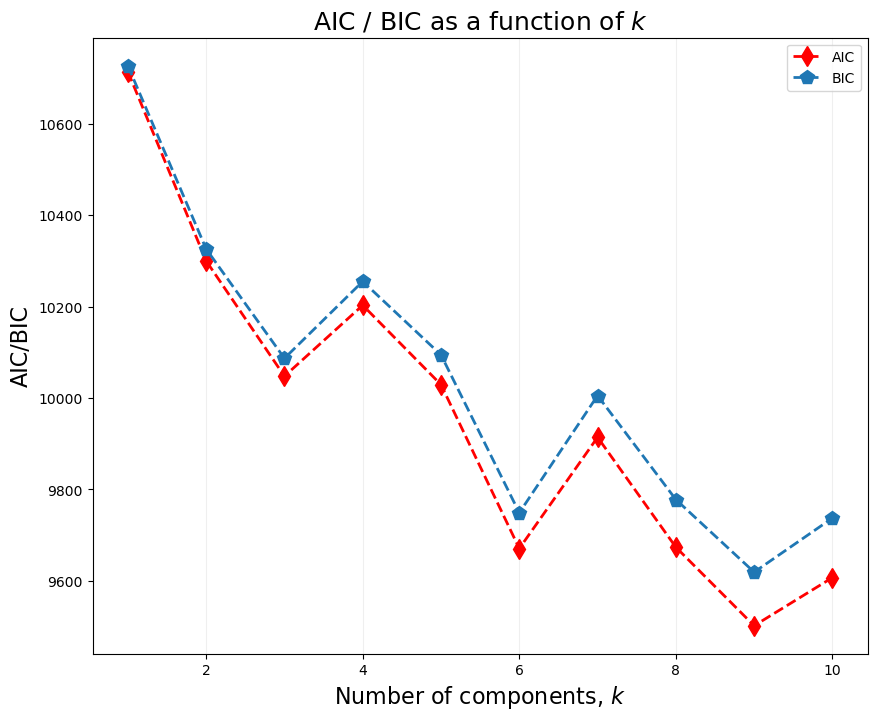

In [17]:
# Calculate average silhouette score for each k

# Calculate AIC and BIC for each k
n_samples, n_features = Y.shape

aics = [n_samples * np.log(log_likelihood) + 2 * k * n_features for k, log_likelihood in zip(range(1, max_k + 1), log_lkhd)]
bics = [n_samples * np.log(log_likelihood) + k * np.log(n_samples) * n_features for k, log_likelihood in zip(range(1, max_k + 1), log_lkhd)]

# Plot AIC and BIC vs k
plt.figure(figsize=(10,8))
plt.title('AIC / BIC as a function of $k$')
plt.plot(range(1, max_k + 1), aics, 'r--', marker='d')
plt.plot(range(1, max_k + 1), bics, 'p--')
plt.ylabel('AIC/BIC')
plt.xlabel('Number of components, $k$')
plt.legend(['AIC', 'BIC'])
plt.show()


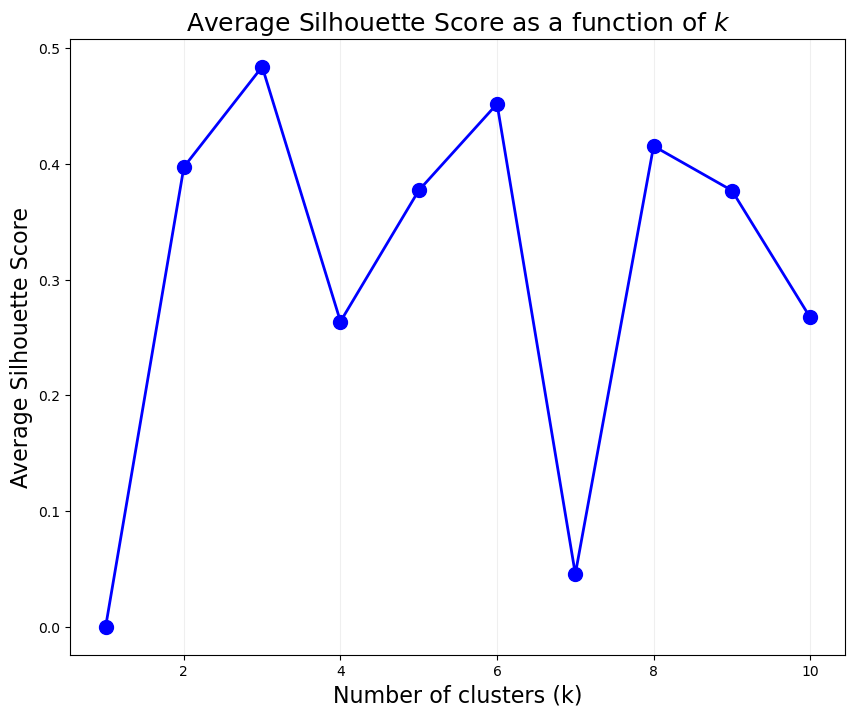

In [18]:
# your code here

avg_silhouette_scores = [np.mean(scores) for scores in sil_scores]

# Plot average silhouette score vs k
plt.figure(figsize=(10, 8))
plt.title('Average Silhouette Score as a function of $k$')
plt.plot(range(1, max_k + 1), avg_silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score');

In [19]:
# your code here
...

<div class='exercise-r'>

**1.9**  
    
Which value of $k$ is suggested by each of the 3 metrics? Are they in agreement? Do you trust in some of these metrics more than others? If so, explain why, supporting your poisition based on your understanding of the data, our clustering algorithm, and what the metrics reward and/or penalize. 

</div>

To choose a value of $k$ using the silhouette score, we select the number of clusters that maximizes the overall silhouette score. In this case, this is equivalent to $k=3$. 

AIC and BIC are measures used to compare different models, with lower values indicating better model fit. Hence, we need to choose the model with the lowest AIC or BIC value, which in this case is for $k=9$. 

They are not in agreement. This is because compared to the silhouette score, AIC/BIC tends to prefer models with more clusters, meaning it may select a larger number of clusters, which may result in a lower silhouette score because the clusters are less well separated. Alternatively, the silhouette score may suggest a smaller number of clusters than AIC/BIC because it is more concerned with the quality of clustering. 

AIC/BIC are well-suited for data that follow a parametric distribution, where the model assumptions are known and can be described by a finite set of parameters. This is why AIC/BIC may be a better measure in this case. The silhouette score, on the other hand, is a non-parametric measure of the quality of clustering that is well-suited for a variety of data types. It does not require any assumptions about the underlying distribution of the data and can be used with any clustering algorithm.  

AIC is calculated as: $AIC = 2k - 2ln(L)$, where $k$ is the number of parameters in the model and $L$ is the likelihood of the data given the model. BIC is calculated as $BIC = kln(n) - 2ln(L)$, where $n$ is the sample size. Both AIC and BIC have a penalty term that increases with the number of parameters in the model, so they tend to favor simpler models with fewer parameters. This can help prevent overfitting and produce a more accurate and generalizable clustering solution. In addition, AIC and BIC are both based on rigorous statistical principles, which makes them more objective and less prone to bias than other methods, such as visual inspection of clustering results or subjective assessment of cluster quality.

<div class='exercise-r'>

**1.10** 
    
Now let's try scikit-learn's [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (imported as `GMM`).
    
Fit a series of GMMs with $k$ components for $k \in$ {1, 2, ..., 10} using  `random_state` 42 and `n_init=10`.
    
Next, compute each model's AIC and BIC and display them in a single plot how both AIC and BIC values change with the number of model components used.
    
Which value of $k$ is optimal according to each criterion?
    
*Note: You should also use `covariance_type="full"` and `init_params='random_from_data'` so it is similar to your from-scratch implementation above*

*Hint: Don't forget to consult the `GaussianMixture` documentation*

</div>

The lower the value of AIC or BIC, the better the trade-off between model complexity and goodness of fit. Both AIC and BIC have a penalty term that increases with the number of parameters in the model, so they tend to favor simpler models with fewer parameters (even though they favour models with more clusters than the silhouette scores). However, BIC has a stronger penalty than AIC for the number of parameters, which tends to favor even simpler models than AIC. This is why AIC suggests the optimal $k$ as $8$, and BIC as $6$. 

In general, the AIC is preferred when the goal is to maximize the predictive accuracy of the model, while the BIC is preferred when the goal is to identify the true underlying model. This is why in this case it would be more interesting to choose the clusters based on the AIC rule. 

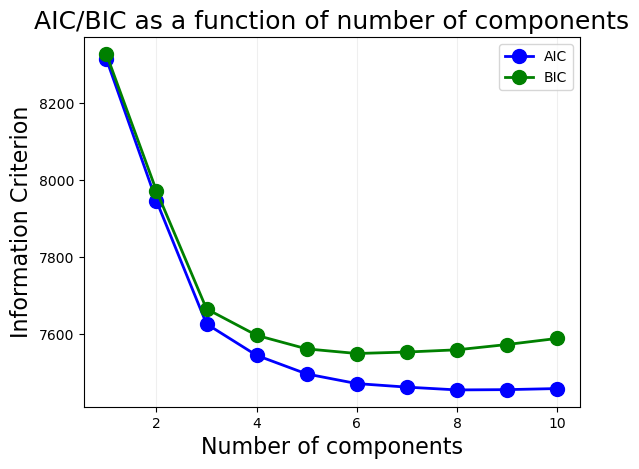

In [20]:
# your code here
# Fit a series of GMMs with k components
k_range = range(1, 11)
gmm_models = [GMM(n_components=k, random_state=42, 
                  covariance_type="full", 
                  init_params='random_from_data',
                  n_init=10).fit(Y) for k in k_range]

# Compute AIC and BIC for each model
n_samples, n_features = Y.shape
log_likelihoods = [model.score(Y) for model in gmm_models]

aics = [n_samples * np.log(-log_likelihood) + 2 * k * n_features for k, log_likelihood in zip(range(1, max_k + 1), log_likelihoods)]
bics = [n_samples * np.log(-log_likelihood) + k * np.log(n_samples) * n_features for k, log_likelihood in zip(range(1, max_k + 1), log_likelihoods)]

# Plot AIC and BIC values as a function of number of components
plt.title('AIC/BIC as a function of number of components')
plt.plot(k_range, aics, 'bo-', label='AIC')
plt.plot(k_range, bics, 'go-', label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.show()

<div class='exercise-r'>

**1.11** 
    
Use the metric plots to decide on a choice of $k$.
    
Then use `plot_gaussians` to visualize the GMM model fit with this choice of $k$ and a random state of `109`.
    
Compare your choice of $k$ with the variable `K_true`, the actual number of of Gaussians from which this data was generated. Do you think the GMM performed well at finding the underlying structure in the data? Name at least one very clear advantage SKLearn's implementation of GMM has over the your from-scratch implementation.

</div>

Our current choice of $k$ is lower than `K_true`. However, based on the plot we can see that it that there are clusters that are not adequately captured by the GMM. All the way at the bottom of the plot in the middle could've easily been another cluster, as well as a few points in the North-West.

One clear advantage over the from-scratch implementation is sklearn's ability to optimize the EM algorithm, which is very computationally intensive. This can be particularly advantageous when working with large datasets or when you need to perform clustering in real-time or near real-time applications

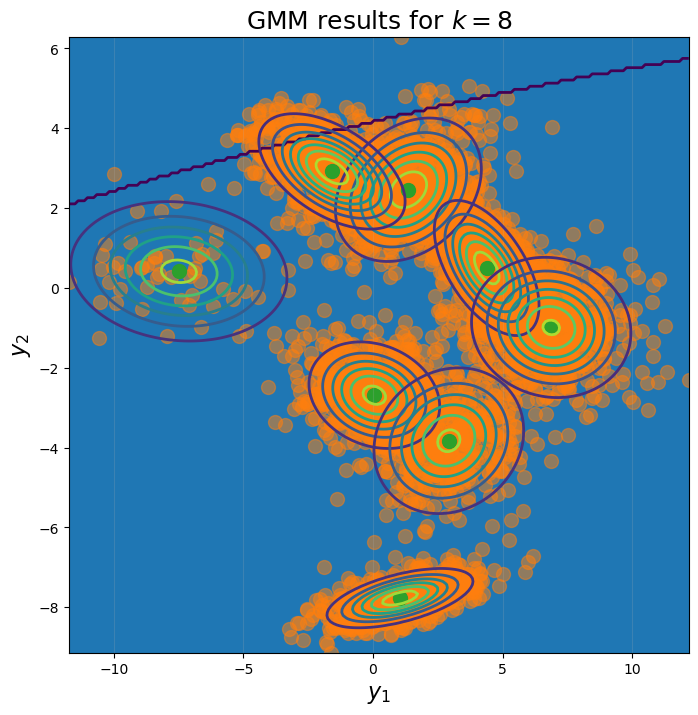

In [21]:
# your code here

# Set the best number of clusters found using AIC
best_k = 8

# Fit a Gaussian mixture model with the best number of clusters
best_k_GMM = GMM(n_components=best_k, random_state=42, n_init=10).fit(Y)

# Plot the Gaussian mixture model with the best number of clusters
plot_gaussians(Y, best_k_GMM.weights_, best_k_GMM.means_, best_k_GMM.covariances_)

<div class='exercise-r'>

**1.12** 
    
Considering the differences between the two methods, describe at least 3 clear advantages the GMM approach has over KMeans when performing clustering.

</div>

- Flexibility in cluster shapes: K-means assumes that the clusters have spherical shapes and does not perform well when clusters have non-spherical shapes. In contrast, GMMs can model clusters with a more diverse range of shapes by using a combination of Gaussian distributions. GMMs are more flexible and can handle a wider range of cluster shapes than K-means.

- Mixed data types: K-means is designed to work with continuous numerical data and does not handle categorical data well. GMMs can model both continuous and categorical data types by using a combination of Gaussian distributions for continuous variables and discrete probability distributions for categorical variables. This makes GMMs more versatile and allows them to handle a wider range of data types than K-means.

- Soft clustering: K-means performs hard clustering, which assigns each data point to one and only one cluster. In contrast, GMMs perform soft clustering by assigning a probability of a data point belonging to a particular cluster. This can be useful in cases where data points may belong to multiple clusters or where the boundaries between clusters are not well-defined.



**This concludes HW1-209. Thank you!**